In [1]:
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR = 0.0003
EPS =  np.finfo(np.float32).eps
V_MAX = 10.
V_MIN = -10.
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class CategoricalDuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_atoms)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space * n_atoms)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1, N_ATOMS)
        adv_out = self.adv(out).reshape(out.shape[0], -1, N_ATOMS)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        out = val_out + adv_out - adv_mean
        out = self.log_softmax(out)
        probs = out.exp()

        return probs

In [4]:
losses = []


def learn(net, tgt_net, net_optim, rep_memory):
    net.train()
    tgt_net.train()

    dataloader = DataLoader(rep_memory,
                            shuffle=True,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)
    # like a double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        if i > 0:
            break
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        rewards = r.detach().cpu().numpy()
        dones = d.detach().cpu().numpy()

        _p_batch = net(_s_batch)
        _weights = _p_batch * net.support
        _q_batch = _weights.sum(dim=2)
        _action_batch = torch.argmax(_q_batch, dim=1).long()

        with torch.no_grad():
            tgt_p_batch = tgt_net(_s_batch)
            _p_best = tgt_p_batch[range(BATCH_SIZE), _action_batch]

        proj_p = projection(_p_best, rewards, dones)

        p_batch = net(s_batch)
        p_acting = p_batch[range(BATCH_SIZE), a_batch.data]

        # loss
        loss = -(proj_p * torch.clamp(p_acting, min=EPS).log()).sum(dim=1).mean()
        losses.append(loss)

        net_optim.zero_grad()
        loss.backward()
        net_optim.step()


def projection(next_p, rewards, dones):
    next_p = next_p.cpu().numpy()
    proj_p = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    for atom in range(N_ATOMS):
        z = np.minimum(V_MAX, np.maximum(
            V_MIN, rewards + (V_MIN + atom * DELTA_Z) * GAMMA))
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)

        eq_mask = u == l
        proj_p[eq_mask, l[eq_mask]] += next_p[eq_mask, atom]
        ne_mask = u != l
        proj_p[ne_mask, l[ne_mask]] += next_p[ne_mask, atom] * (u - b)[ne_mask]
        proj_p[ne_mask, u[ne_mask]] += next_p[ne_mask, atom] * (b - l)[ne_mask]

        if dones.any():
            proj_p[dones] = 0.0
            z = np.minimum(V_MAX, np.maximum(V_MIN, rewards[dones]))
            b = (z - V_MIN) / DELTA_Z
            l = np.floor(b).astype(np.int64)
            u = np.ceil(b).astype(np.int64)

            eq_mask = u == l
            eq_dones = dones.copy()
            eq_dones[dones] = eq_mask
            if eq_dones.any():
                proj_p[eq_dones, l] = 1.0

            ne_mask = u != l
            ne_dones = dones.copy()
            ne_dones[dones] = ne_mask
            if ne_dones.any():
                proj_p[ne_dones, l] = (u - b)[ne_mask]
                proj_p[ne_dones, u] = (b - l)[ne_mask]

    return torch.tensor(proj_p).to(device).float()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        probs = target_net(state)
        weights = probs * net.support
        q = weights.sum(dim=2)
        action = torch.argmax(q)

    return action.item()

## Main

In [5]:
# make an environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
up_coef = 1
use_eps_decay = True
epsilon = 1
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make four nerual networks
net = CategoricalDuelingDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)

# make optimizer
net_optim = torch.optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

195.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n====================  Start Learning  ====================\n')
                is_learned = True
            learn(net, target_net, net_optim, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = up_coef * n.data + (1 - up_coef) * t.data
            learn_steps = 0

    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'../test/saved_models/{env.spec.id}_ep{i}_clear_model_cdddqn_r.pt')
                break
env.close()

  1 Episode in    12 steps, reward 12.00
  2 Episode in    27 steps, reward 15.00
  3 Episode in    47 steps, reward 20.00
  4 Episode in    66 steps, reward 19.00
  5 Episode in    76 steps, reward 10.00
  6 Episode in    97 steps, reward 21.00
  7 Episode in   129 steps, reward 32.00
  8 Episode in   177 steps, reward 48.00
  9 Episode in   191 steps, reward 14.00
 10 Episode in   203 steps, reward 12.00
 11 Episode in   222 steps, reward 19.00
 12 Episode in   262 steps, reward 40.00
 13 Episode in   296 steps, reward 34.00
 14 Episode in   313 steps, reward 17.00
 15 Episode in   326 steps, reward 13.00
 16 Episode in   349 steps, reward 23.00
 17 Episode in   365 steps, reward 16.00
 18 Episode in   405 steps, reward 40.00
 19 Episode in   426 steps, reward 21.00
 20 Episode in   447 steps, reward 21.00
 21 Episode in   493 steps, reward 46.00
 22 Episode in   531 steps, reward 38.00
 23 Episode in   565 steps, reward 34.00
 24 Episode in   580 steps, reward 15.00
 25 Episode in  

200 Episode in  3907 steps, reward 10.00
201 Episode in  3919 steps, reward 12.00
202 Episode in  3930 steps, reward 11.00
203 Episode in  3943 steps, reward 13.00
204 Episode in  3953 steps, reward 10.00
205 Episode in  3972 steps, reward 19.00
206 Episode in  3983 steps, reward 11.00
207 Episode in  3994 steps, reward 11.00
208 Episode in  4005 steps, reward 11.00
209 Episode in  4020 steps, reward 15.00
210 Episode in  4048 steps, reward 28.00
211 Episode in  4059 steps, reward 11.00
212 Episode in  4082 steps, reward 23.00
213 Episode in  4090 steps, reward 8.00
214 Episode in  4098 steps, reward 8.00
215 Episode in  4108 steps, reward 10.00
216 Episode in  4119 steps, reward 11.00
217 Episode in  4131 steps, reward 12.00
218 Episode in  4152 steps, reward 21.00
219 Episode in  4173 steps, reward 21.00
220 Episode in  4196 steps, reward 23.00
221 Episode in  4208 steps, reward 12.00
222 Episode in  4226 steps, reward 18.00
223 Episode in  4237 steps, reward 11.00
224 Episode in  42

402 Episode in  7033 steps, reward 12.00
403 Episode in  7044 steps, reward 11.00
404 Episode in  7056 steps, reward 12.00
405 Episode in  7070 steps, reward 14.00
406 Episode in  7079 steps, reward 9.00
407 Episode in  7091 steps, reward 12.00
408 Episode in  7100 steps, reward 9.00
409 Episode in  7111 steps, reward 11.00
410 Episode in  7130 steps, reward 19.00
411 Episode in  7145 steps, reward 15.00
412 Episode in  7172 steps, reward 27.00
413 Episode in  7183 steps, reward 11.00
414 Episode in  7193 steps, reward 10.00
415 Episode in  7206 steps, reward 13.00
416 Episode in  7214 steps, reward 8.00
417 Episode in  7224 steps, reward 10.00
418 Episode in  7235 steps, reward 11.00
419 Episode in  7246 steps, reward 11.00
420 Episode in  7261 steps, reward 15.00
421 Episode in  7273 steps, reward 12.00
422 Episode in  7285 steps, reward 12.00
423 Episode in  7299 steps, reward 14.00
424 Episode in  7309 steps, reward 10.00
425 Episode in  7320 steps, reward 11.00
426 Episode in  733

603 Episode in  9647 steps, reward 46.00
604 Episode in  9658 steps, reward 11.00
605 Episode in  9666 steps, reward 8.00
606 Episode in  9674 steps, reward 8.00
607 Episode in  9682 steps, reward 8.00
608 Episode in  9692 steps, reward 10.00
609 Episode in  9702 steps, reward 10.00
610 Episode in  9713 steps, reward 11.00
611 Episode in  9723 steps, reward 10.00
612 Episode in  9732 steps, reward 9.00
613 Episode in  9752 steps, reward 20.00
614 Episode in  9767 steps, reward 15.00
615 Episode in  9780 steps, reward 13.00
616 Episode in  9789 steps, reward 9.00
617 Episode in  9799 steps, reward 10.00
618 Episode in  9811 steps, reward 12.00
619 Episode in  9822 steps, reward 11.00
620 Episode in  9839 steps, reward 17.00
621 Episode in  9853 steps, reward 14.00
622 Episode in  9865 steps, reward 12.00
623 Episode in  9874 steps, reward 9.00
624 Episode in  9884 steps, reward 10.00
625 Episode in  9893 steps, reward 9.00
626 Episode in  9903 steps, reward 10.00
627 Episode in  9912 st

805 Episode in 11923 steps, reward 12.00
806 Episode in 11932 steps, reward 9.00
807 Episode in 11946 steps, reward 14.00
808 Episode in 11954 steps, reward 8.00
809 Episode in 11964 steps, reward 10.00
810 Episode in 11973 steps, reward 9.00
811 Episode in 11981 steps, reward 8.00
812 Episode in 11990 steps, reward 9.00
813 Episode in 12004 steps, reward 14.00
814 Episode in 12014 steps, reward 10.00
815 Episode in 12025 steps, reward 11.00
816 Episode in 12039 steps, reward 14.00
817 Episode in 12050 steps, reward 11.00
818 Episode in 12066 steps, reward 16.00
819 Episode in 12075 steps, reward 9.00
820 Episode in 12085 steps, reward 10.00
821 Episode in 12094 steps, reward 9.00
822 Episode in 12105 steps, reward 11.00
823 Episode in 12114 steps, reward 9.00
824 Episode in 12123 steps, reward 9.00
825 Episode in 12133 steps, reward 10.00
826 Episode in 12145 steps, reward 12.00
827 Episode in 12155 steps, reward 10.00
828 Episode in 12166 steps, reward 11.00
829 Episode in 12176 step

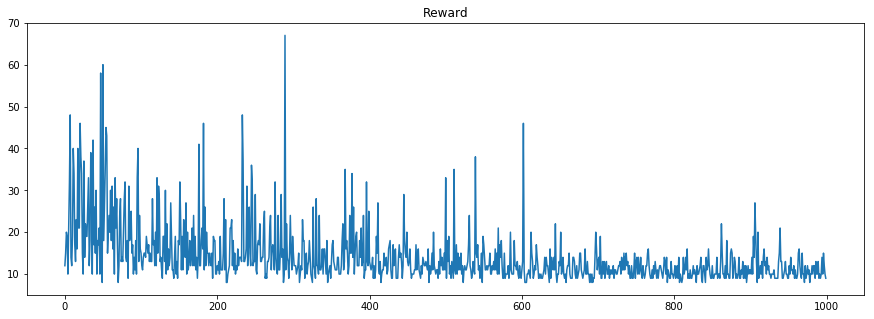

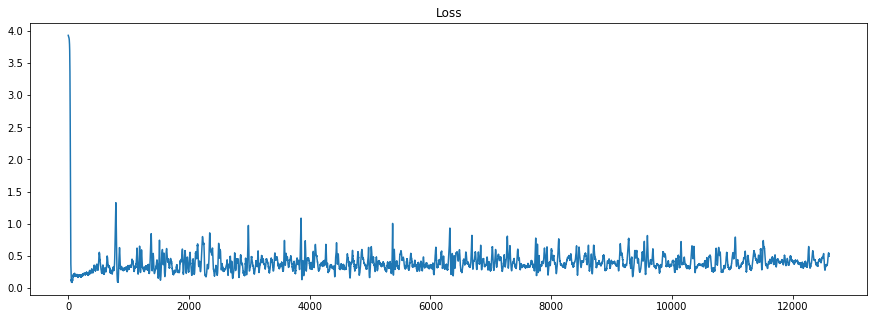

NameError: name 'f_losses' is not defined

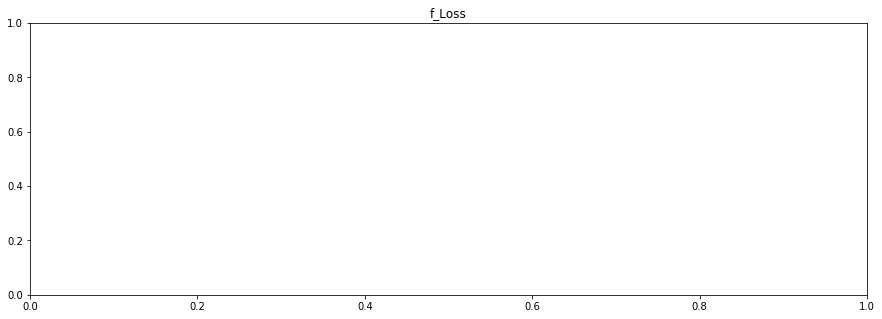

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()